<a href="https://colab.research.google.com/github/danilovabg/coursera/blob/master/Machine%20Learning%20with%20PySpark%3A%20Customer%20Churn%20Analysis/Deep_Learning_PyTorch_Siamese_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=4c5fabbd9f95e578747962cb9aeae6062b07ec269a58beba7d4bea21be2ebb50
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=61cf1bf313fef6c74c9887de94629

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 9.29 MiB/s, done.


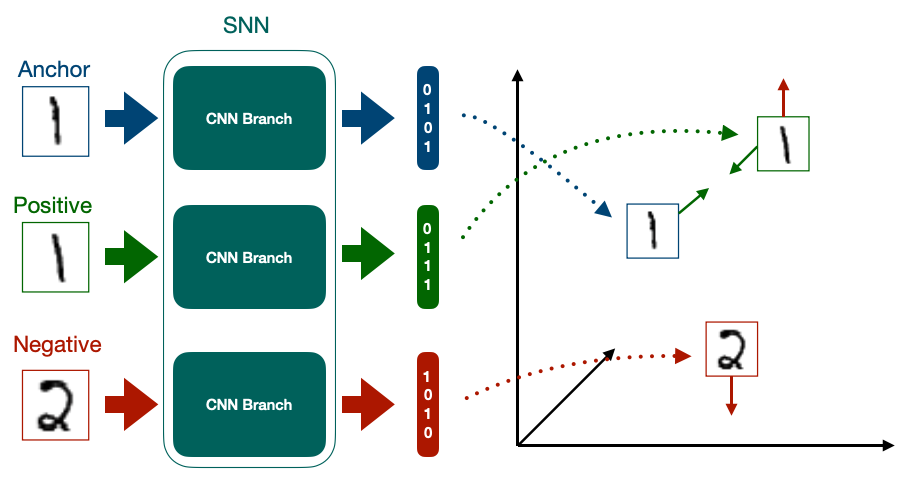

# Imports

In [3]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [36]:
data_dir = '/content/Person-Re-Id-Dataset/train/'
file = '/content/Person-Re-Id-Dataset/train.csv'
batch_size = 32
lr = 1e-3
epochs = 15
device = 'cuda'

In [6]:
df = pd.read_csv(file)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [17]:
row = df.iloc[7]
a_img = io.imread(data_dir + row['Anchor'])
p_img = io.imread(data_dir + row['Positive'])
n_img = io.imread(data_dir + row['Negative'])

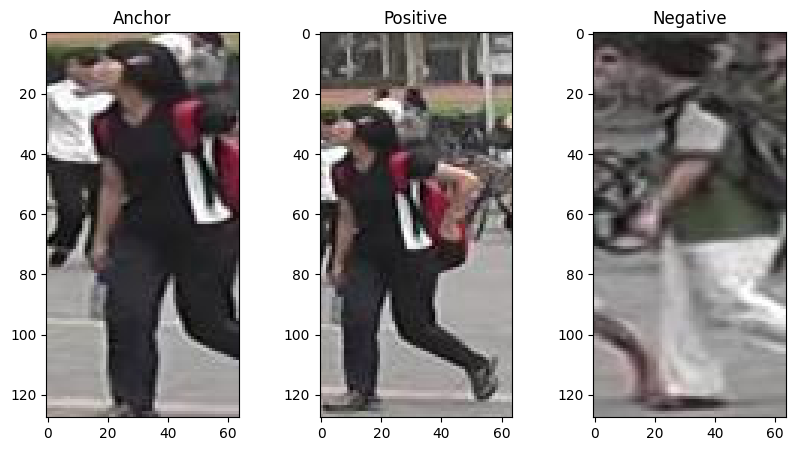

In [18]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 5))
ax1.set_title('Anchor')
ax1.imshow(a_img)

ax2.set_title('Positive')
ax2.imshow(p_img)

ax3.set_title('Negative')
ax3.imshow(n_img)

In [23]:
train_df, test_df = train_test_split(df, test_size = 0.2, random_state=42)

# Create APN Dataset

In [22]:
class APN_DataSet(Dataset):

  def __init__(self, df):

    self.df = df

  def __len__(self):

    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]
    a_img = io.imread(data_dir + row['Anchor'])
    p_img = io.imread(data_dir + row['Positive'])
    n_img = io.imread(data_dir + row['Negative'])

    a_img = torch.from_numpy(a_img).permute(2, 0, 1)/255
    p_img = torch.from_numpy(p_img).permute(2, 0, 1)/255
    n_img = torch.from_numpy(n_img).permute(2, 0, 1)/255

    return a_img, p_img, n_img

In [25]:
train_set = APN_DataSet(train_df)
test_set = APN_DataSet(test_df)

print(f'Size of train set {len(train_set)}')
print(f'Size of test set {len(test_set)}')

Size of train set 3200
Size of test set 800


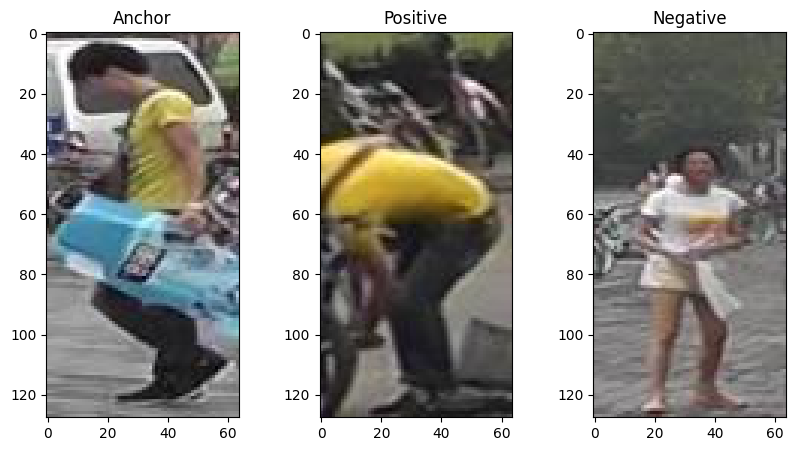

In [26]:
idx = 40
A,P,N = train_set[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [27]:
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle = True)
testloader = DataLoader(test_set, batch_size=batch_size)

In [29]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(testloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [30]:
for a, p, n in trainloader:
  break

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([3, 128, 64])


# Create Model

In [32]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
      super(APN_Model, self).__init__()

      self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
      self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):
      embeddings = self.efficientnet(images)

      return embeddings


In [33]:
model = APN_Model()

In [37]:
model.to(device)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval function

In [45]:
def train_df(model, dataloader, optimizer, criterion):

    model.train()
    total_loss = 0.0

    for A, P, N in tqdm(dataloader):
        A, P, N = A.to(device), P.to(device), N.to(device)

        A_emb, P_emb, N_emb = model(A), model(P), model(N)

        loss = criterion(A_emb, P_emb, N_emb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss/len(dataloader)

In [46]:
def eval_df(model, dataloader, criterion):

    model.eval()
    train_loss = 0.0

    with torch.no_grad():
        for A, P, N in tqdm(dataloader):
            A, P, N = A.to(device), P.to(device), N.to(device)

            A_emb, P_emb, N_emb = model(A), model(P), model(N)

            loss = criterion(A_emb, P_emb, N_emb)
            train_loss += loss.item()

        return train_loss/len(dataloader)

In [47]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# Create Training Loop

In [48]:
best_test_loss = np.Inf

for i in range(epochs):
    train_loss = train_df(model, trainloader, optimizer, criterion)
    test_loss = eval_df(model, testloader, criterion)

    if test_loss < best_test_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        best_test_loss = test_loss
        print('saved of weights success')
    print(f'Epoch: {i+1} train loss: {train_loss: .3f}, test loss {test_loss:.3f}')

100%|██████████| 25/25 [00:02<00:00,  9.10it/s]


saved of weights success
Epoch: 1 train loss:  0.608, test loss 0.532


100%|██████████| 25/25 [00:02<00:00,  9.65it/s]


saved of weights success
Epoch: 2 train loss:  0.341, test loss 0.337


100%|██████████| 25/25 [00:02<00:00,  9.48it/s]


Epoch: 3 train loss:  0.214, test loss 0.340


100%|██████████| 25/25 [00:03<00:00,  7.70it/s]


saved of weights success
Epoch: 4 train loss:  0.133, test loss 0.189


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Epoch: 5 train loss:  0.089, test loss 0.239


100%|██████████| 25/25 [00:02<00:00,  9.30it/s]


Epoch: 6 train loss:  0.113, test loss 0.197


100%|██████████| 25/25 [00:02<00:00,  9.40it/s]


saved of weights success
Epoch: 7 train loss:  0.050, test loss 0.126


100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


Epoch: 8 train loss:  0.041, test loss 0.147


100%|██████████| 25/25 [00:02<00:00,  9.34it/s]


Epoch: 9 train loss:  0.031, test loss 0.196


100%|██████████| 25/25 [00:02<00:00,  9.11it/s]


Epoch: 10 train loss:  0.041, test loss 0.199


100%|██████████| 25/25 [00:05<00:00,  4.55it/s]


Epoch: 11 train loss:  0.069, test loss 0.197


100%|██████████| 25/25 [00:04<00:00,  5.55it/s]


Epoch: 12 train loss:  0.038, test loss 0.168


100%|██████████| 25/25 [00:02<00:00,  9.67it/s]


Epoch: 13 train loss:  0.045, test loss 0.204


100%|██████████| 25/25 [00:02<00:00,  9.43it/s]


Epoch: 14 train loss:  0.032, test loss 0.172


100%|██████████| 25/25 [00:04<00:00,  5.47it/s]

Epoch: 15 train loss:  0.035, test loss 0.156


# Get Anchor Embeddings

In [58]:
def get_encoding_csv(model, anc_img_names):
    anc_images_array = np.array(anc_img_names)
    encodings = []

    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_images_array):
            A = io.imread(data_dir + i)
            A = torch.from_numpy(A).permute(2, 0, 1)/ 255
            A = A.to(device)
            A_enc = model(A.unsqueeze(0))
            encodings.append(A_enc.squeeze().cpu().detach().numpy())
        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis = 1)

    return df_enc


In [59]:
model.load_state_dict(torch.load('best_model.pt'))

df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [00:42<00:00, 94.79it/s] 


In [60]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.732628,0.211541,-1.056936,-0.173849,0.427467,-0.637681,-0.768025,0.305497,0.286861,...,0.681455,1.490983,0.730332,0.230705,-0.305545,0.333505,0.713618,-1.104617,-0.385846,0.429540
1,1420_c3s3_061978_03.jpg,-0.209623,-0.176365,-0.654330,-0.698093,0.227731,-0.702460,-0.942799,0.462768,0.265425,...,0.409379,1.293069,0.192069,-0.122544,0.241590,0.608545,0.603164,-0.695722,-0.651782,0.162079
2,1420_c5s3_062565_05.jpg,-0.308035,-0.244879,-0.369691,-0.254522,0.168118,-0.880388,-0.504646,0.565609,0.092039,...,0.579783,0.712161,0.595398,-0.051650,0.066626,0.279677,0.411673,-0.744556,-0.406035,0.511169
3,1420_c6s3_085592_04.jpg,-0.180160,-0.026114,-0.915408,-0.497718,0.998534,-0.285059,-0.737815,-0.177692,0.612113,...,0.222378,1.760263,0.571488,0.642625,-0.402321,0.444825,0.752586,-1.375554,-0.270941,0.050674
4,0663_c5s3_085987_03.jpg,-0.059411,-0.455387,0.254846,0.233374,-0.387238,0.089654,0.352251,0.045969,-0.032442,...,0.504820,-0.273367,0.510201,-0.321633,-0.227994,-0.110938,-0.231234,0.366672,0.027835,0.021102


# Inference

In [63]:
def euqlid_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc-anc_enc_arr).T))
    return dist

In [74]:
idx = 10
img_name = df_enc['Anchor'].iloc[idx]
img_path = data_dir + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0 , 1)/255

model.eval()
with torch.no_grad():
    img = img.to(device)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()


In [75]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [76]:
distance = []

for i in range(anc_enc_arr.shape[0]):
    dist = euqlid_dist(img_enc, anc_enc_arr[i:i+1, :])
    distance = np.append(distance, dist)


In [77]:
closest_idx = np.argsort(distance)

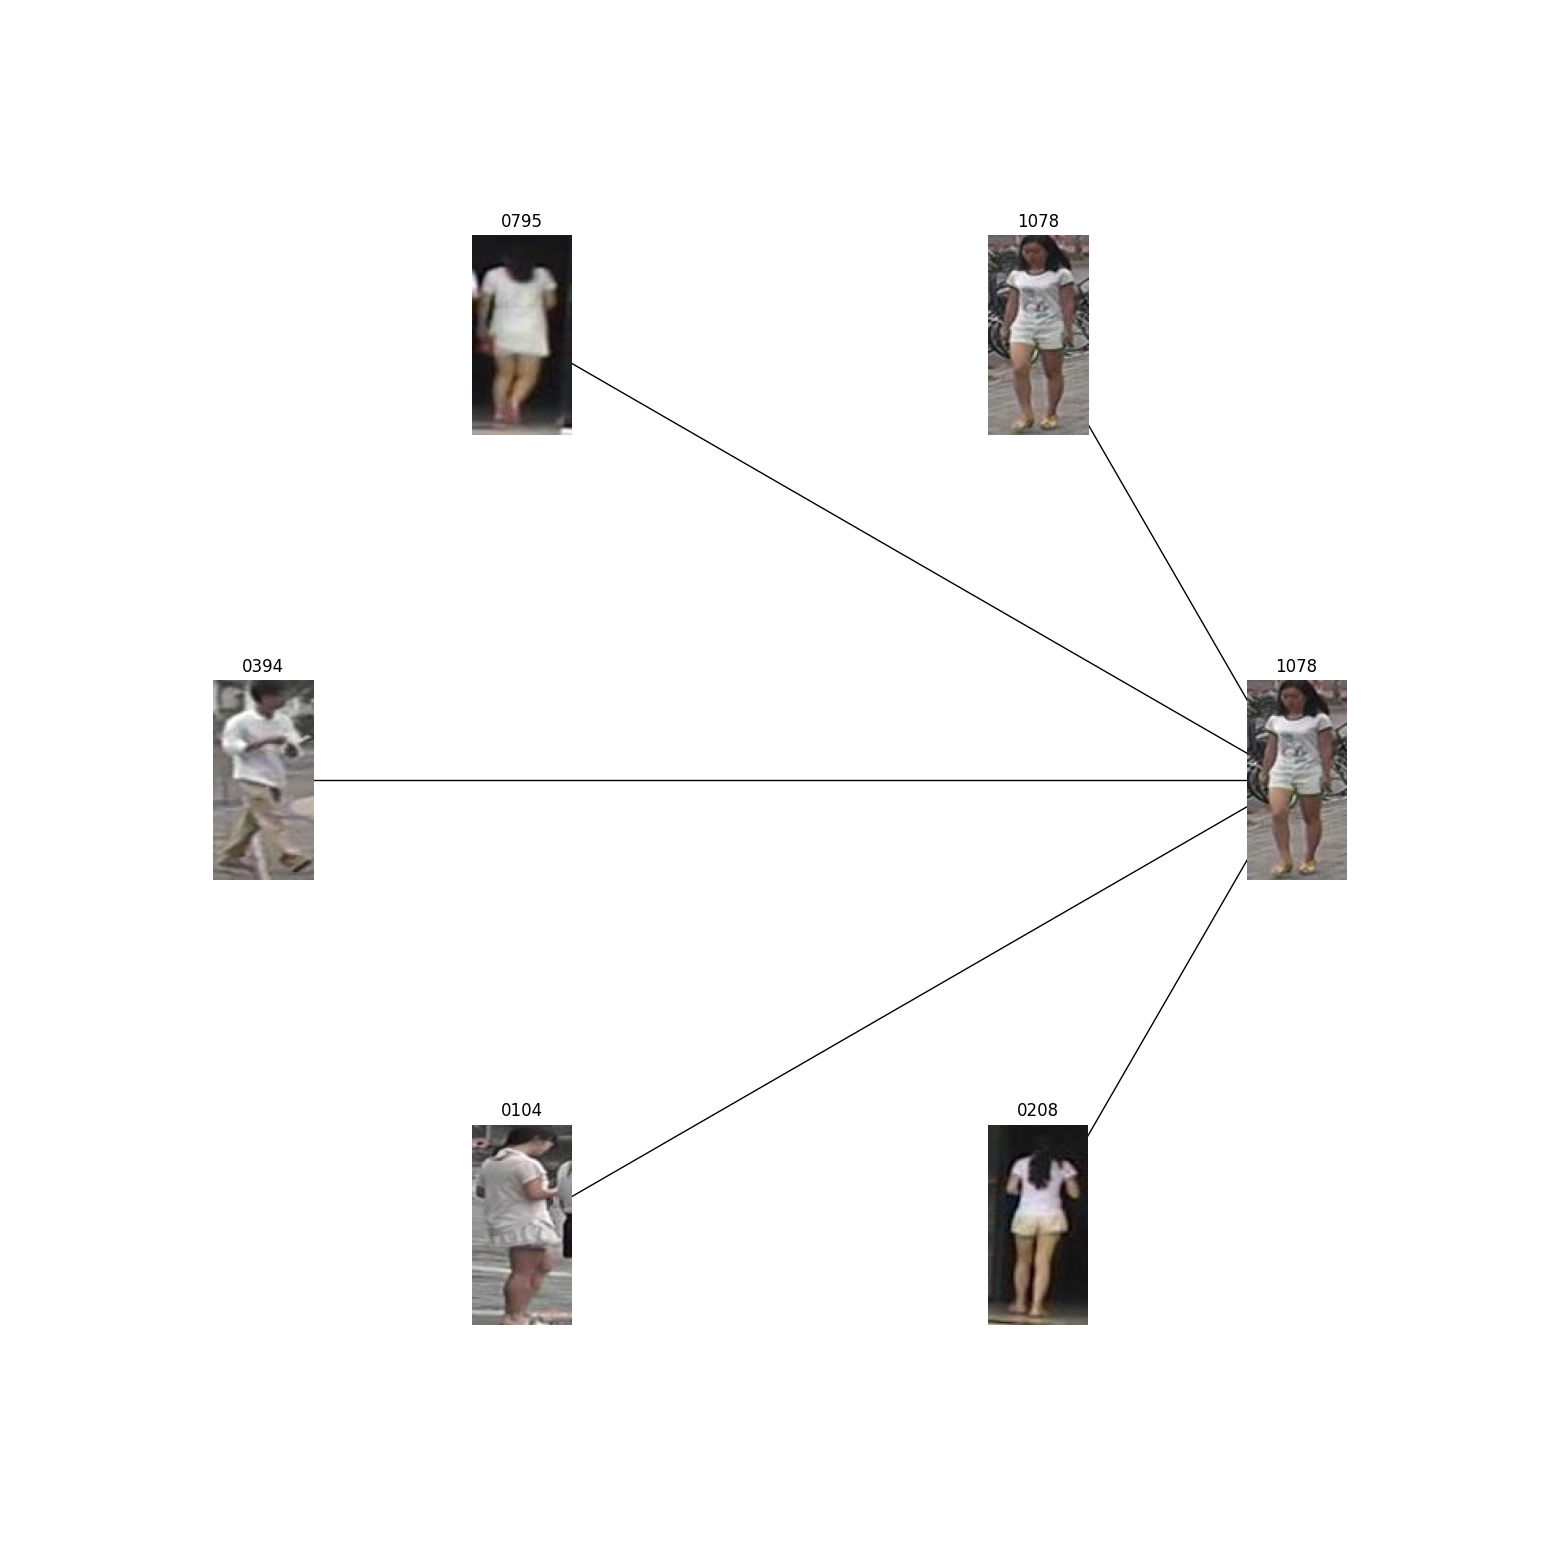

In [78]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, data_dir, img, img_path, closest_idx, distance, no_of_closest = 5);